### Segmentation of a blood vessel dataset containing large images

The training is done by randomly croping the images instead of using the entire images.

To download the dataset, run the following cell:

In [1]:
#from dataset_vessel_crop import download
#download(directory='data')

100%|██████████| 98845463/98845463 [00:03<00:00, 30517804.99it/s]


Extracting data\vessel_crop.tar.gz to data


In [1]:
import random
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import train_vessel_crop_pytorch as train_pytorch
import train_vessel_crop_lightning as train_lightning
import torchtrainer

params = {
    # Dataset
    'img_dir': Path('data/vessel_crop/images'),
    'label_dir': Path('data/vessel_crop/labels'),
    'crop_size': (256, 256),          
    'train_val_split': 0.1,
    # Model
    'model_layers': (1, 1, 1), 
    'model_channels': (16,32,64), 
    'model_type': 'unet',
    # Training
    'epochs': 20,
    'lr': 0.01,
    'batch_size_train': 8,
    'batch_size_valid': 8, #132,
    'momentum': 0.9,
    'weight_decay': 0.,
    'seed': 12,
    'loss': 'cross_entropy',
    'scheduler_power': 0.9,
    'class_weights': (0.3414, 0.6586),
    # Efficiency
    'device': 'cuda',
    'num_workers': 3,  # 3 is a good compromise
    'use_amp': True,
    'pin_memory': False,
    'non_blocking': False,
    # Logging
    'log_dir': 'logs',
    'experiment':'unet_l_1_1_1_c_16_32_64',
    'save_every':1,                
    'save_best':True,
    # Other
    'resume': False,
    'meta': None
}

#Train using pure Pytorch
#logger, ds_train, ds_valid, model = train_pytorch.run(params)
#Train using Pytorch Lightning
trainer, ds_train, ds_valid, model = train_lightning.run(params)
logger = trainer.loggers[1]

Global seed set to 12
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | loss_func | CrossEntropyLoss | 0     
1 | model     | ResUNet          | 199 K 
-----------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.800     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


### View results

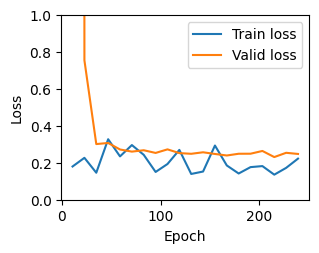

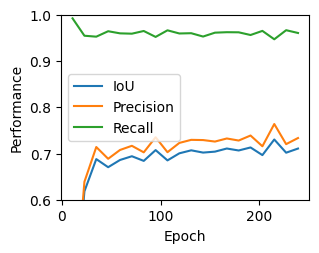

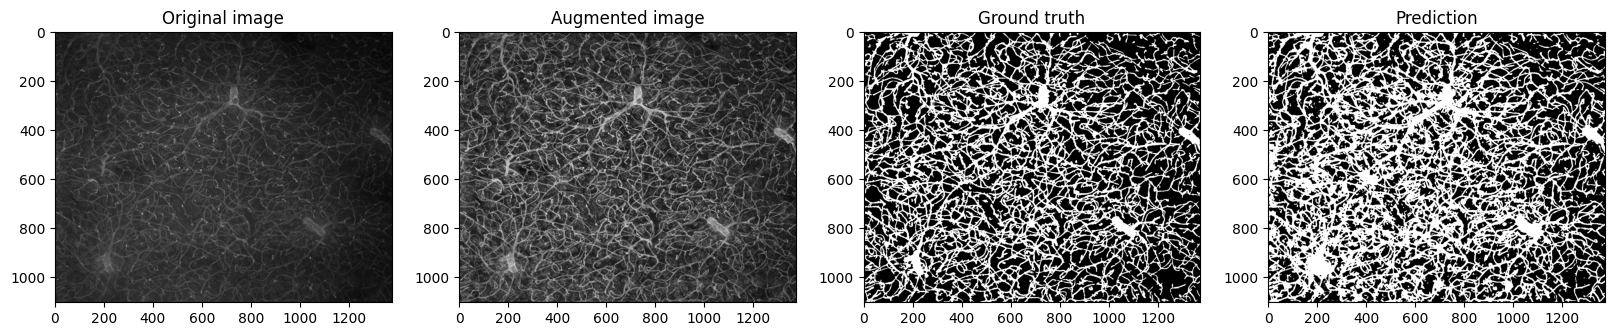

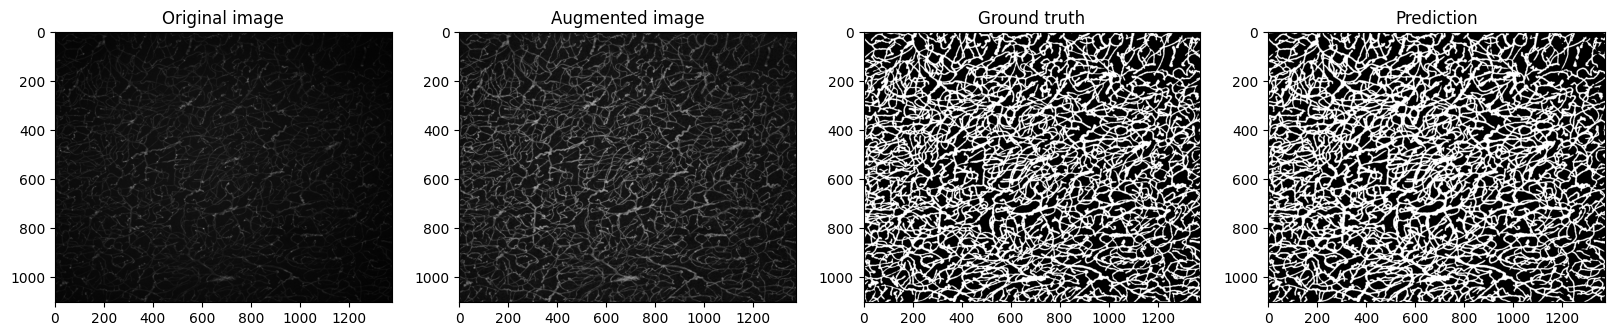

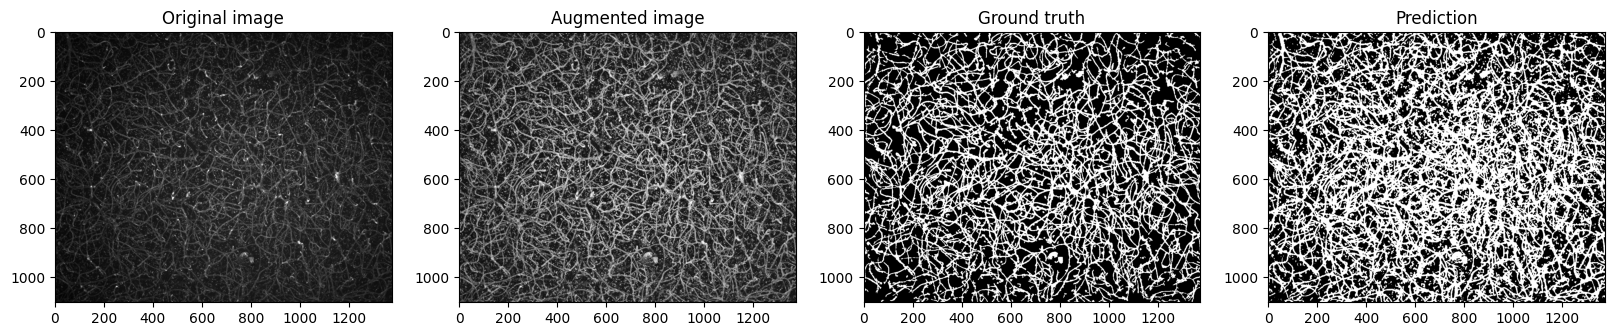

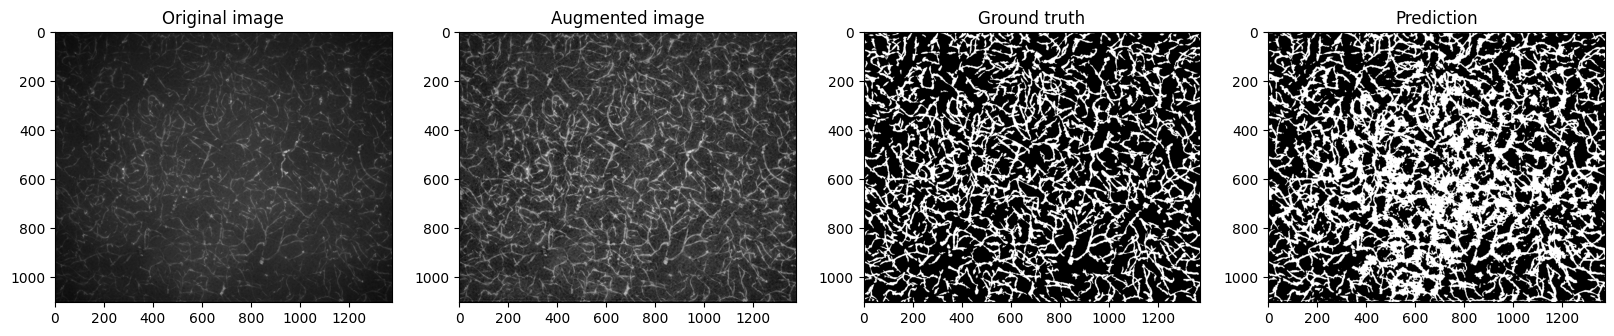

In [2]:
# Plot results
def plot_metrics(logger, type='lt'):
    '''Plot losses and IoU. `lt` is the logger used in Lightning.'''

    if type=='lt':
        metrics = logger.metrics
        epochs, _ = zip(*metrics['val_loss'])
        metrics = [list(zip(*metrics[k]))[1] for k in ['train_loss', 'val_loss', 'iou', 'prec', 'rec']]
        train_loss, valid_loss, iou, prec, rec = metrics    
    elif type=='pt':
        epochs, metrics = zip(*logger.data.items())
        train_loss, valid_loss, iou, prec, rec = zip(*metrics)

    plt.figure()
    plt.plot(epochs, train_loss, label='Train loss')
    plt.plot(epochs, valid_loss, label='Valid loss')
    plt.ylim((0, 1))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.figure()
    plt.plot(epochs, iou, label='IoU')
    plt.plot(epochs, prec, label='Precision')
    plt.plot(epochs, rec, label='Recall')
    plt.ylim((0.6, 1))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Performance')

def plot_examples(ds, model, n=4):
    """Plot some example segmentations"""

    model.eval()
    model.cuda()
    indices = random.sample(range(len(ds)),n)
    for i, idx in enumerate(indices):
        x, y = ds[idx]
        x_or, y_or = ds.get_item(idx)
        with torch.no_grad():
            y_pred = model(x[None].cuda())[0].cpu()
        x = x[0]
        y_pred = torch.max(y_pred, dim=0)[1]

        plt.figure(figsize=[20,5])
        plt.subplot(1, 4, 1)
        plt.imshow(x_or, 'gray')
        plt.title('Original image')
        plt.subplot(1, 4, 2)
        plt.imshow(x, 'gray')
        plt.title('Augmented image')
        plt.subplot(1, 4, 3)
        plt.imshow(y, 'gray')
        plt.title('Ground truth')
        plt.subplot(1, 4, 4)
        plt.imshow(y_pred, 'gray')
        plt.title('Prediction')

plot_metrics(logger, type='lt')
plot_examples(ds_valid, model)

### Analyze model statistics

In [3]:
# Check if output values are too large
model.eval()
model.to('cuda')
stats = []
with torch.no_grad():
    for idx, (x, y) in enumerate(ds_valid):
        if idx%10==0:
            print(idx)
        output = model(x[None].to('cuda'))[0].to('cpu')
        stats.append((idx, output.min(), output.max()))
stats

0


[(0, tensor(-57.4930), tensor(39.4227)),
 (1, tensor(-33.8855), tensor(19.3563)),
 (2, tensor(-27.3130), tensor(16.3099)),
 (3, tensor(-32.4298), tensor(17.2889)),
 (4, tensor(-33.3758), tensor(19.7005)),
 (5, tensor(-22.4370), tensor(13.7724)),
 (6, tensor(-34.1118), tensor(19.4349)),
 (7, tensor(-25.4377), tensor(16.2440)),
 (8, tensor(-38.3400), tensor(25.4189)),
 (9, tensor(-34.8639), tensor(22.0514))]

In [4]:
# Check performance
model.eval()
model.to('cuda')
stats = []
with torch.no_grad():
    for idx, (x, y) in enumerate(ds_valid):
        output = model(x[None].to('cuda')).to('cpu')
        acc = torchtrainer.perf_funcs.segmentation_accuracy(output, y[None], ('iou', 'prec', 'rec'))
        stats.append((idx, *list(acc.items())))
stats

[(0,
  ('iou', tensor(0.8359)),
  ('prec', tensor(0.8385)),
  ('rec', tensor(0.9964))),
 (1,
  ('iou', tensor(0.6090)),
  ('prec', tensor(0.6290)),
  ('rec', tensor(0.9502))),
 (2,
  ('iou', tensor(0.7736)),
  ('prec', tensor(0.8118)),
  ('rec', tensor(0.9426))),
 (3,
  ('iou', tensor(0.6932)),
  ('prec', tensor(0.7027)),
  ('rec', tensor(0.9807))),
 (4,
  ('iou', tensor(0.8578)),
  ('prec', tensor(0.9085)),
  ('rec', tensor(0.9389))),
 (5,
  ('iou', tensor(0.6309)),
  ('prec', tensor(0.6367)),
  ('rec', tensor(0.9859))),
 (6,
  ('iou', tensor(0.7256)),
  ('prec', tensor(0.8124)),
  ('rec', tensor(0.8717))),
 (7,
  ('iou', tensor(0.6940)),
  ('prec', tensor(0.7098)),
  ('rec', tensor(0.9689))),
 (8,
  ('iou', tensor(0.4660)),
  ('prec', tensor(0.4661)),
  ('rec', tensor(0.9996))),
 (9,
  ('iou', tensor(0.7771)),
  ('prec', tensor(0.7807)),
  ('rec', tensor(0.9942)))]

In [5]:
# Check intermediate activations of the model
insp = torchtrainer.inspector.Inspector(model)
insp.start_tracking_activations()

model.eval()
model.to('cuda')
with torch.no_grad():
    output = model(ds_valid[0][0][None].to('cuda'))
acts = insp.get_activations()

stats = []
for k, v in acts.items():
    if v is not None:
        stats.append((k, v.min(), v.max()))
stats

[('resunet.conv1', tensor(-17.9949), tensor(18.5481)),
 ('resunet.bn1', tensor(-12.6160), tensor(14.0587)),
 ('resunet.relu', tensor(0.), tensor(14.0587)),
 ('resunet.encoder.stage_0.0.conv1', tensor(-20.9233), tensor(32.1166)),
 ('resunet.encoder.stage_0.0.bn1', tensor(-15.3175), tensor(17.0416)),
 ('resunet.encoder.stage_0.0.relu1', tensor(0.), tensor(17.0416)),
 ('resunet.encoder.stage_0.0.conv2', tensor(-20.0729), tensor(25.0107)),
 ('resunet.encoder.stage_0.0.bn2', tensor(-19.4784), tensor(22.5714)),
 ('resunet.encoder.stage_0.0.relu2', tensor(0.), tensor(39.6580)),
 ('resunet.encoder.stage_0.0.downsample.0', tensor(-18.5043), tensor(26.8222)),
 ('resunet.encoder.stage_0.0.downsample.1', tensor(-14.6045), tensor(19.3877)),
 ('resunet.encoder.stage_0.0.downsample', tensor(-14.6045), tensor(19.3877)),
 ('resunet.encoder.stage_0.0', tensor(0.), tensor(39.6580)),
 ('resunet.encoder.stage_0', tensor(0.), tensor(39.6580)),
 ('resunet.encoder.stage_1.0.conv1', tensor(-31.0495), tensor(27

In [6]:
# Benchmark model

_model = torchtrainer.models.resunet.ResUNet((3,3,3), (16,32,64))
stats_train = torchtrainer.profiling.benchmark_model(_model, (8, 1, 256, 256), no_grad=False, call_backward=True, use_float16=True, return_model_info=False)
stats_val = torchtrainer.profiling.benchmark_model(_model, (8, 1, 1104, 1376), no_grad=True, call_backward=False, use_float16=True, return_model_info=False)
print(stats_train)
print(stats_val)

{'params': 0.0, 'activations': 0.0, 'flops': 0.0, 'memory': 0.49799489974975586, 'time_cpu': 0.019998788833618164, 'time_gpu': 0.035320831298828126, 'info': ['params: M', 'activations: G', 'flops: G', 'memory: GiB', 'time_cpu: s', 'time_gpu: s']}
{'params': 0.0, 'activations': 0.0, 'flops': 0.0, 'memory': 3.0348448753356934, 'time_cpu': 0.009001731872558594, 'time_gpu': 0.17467698669433593, 'info': ['params: M', 'activations: G', 'flops: G', 'memory: GiB', 'time_cpu: s', 'time_gpu: s']}
